In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider

import comet_ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

#from stumpy import stump, mstump

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import optuna

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(0)

# Setup

In [2]:
train_df = pd.read_csv("./data/train.csv", index_col=0).drop_duplicates()
test_df = pd.read_csv("./data/test_nolabels.csv", index_col=0)

y1_weight = train_df.LABELS.sum() / train_df.shape[0]
# y1_weight = 0.6757894386583703

In [3]:
# Constants to select pandas columns efficiently
# all months abbreviations: jan, feb, mar, etc.
MONTHS = [m.lower() for m in pd.date_range(0, freq="M", periods=12).strftime("%b").to_list()]

# return all columns based on MONTH: train_df[COL_BY_MONTH["jan"]]
COL_BY_MONTH = {}
for month in MONTHS:
    COL_BY_MONTH[month] = [col for col in train_df.columns if month in col]

# all features
FEATURES = [col for col in train_df.columns if col != "LABELS"]
# all features with the month stripped: S2_B2_
COL_BASE = list({col[:-3] for col in FEATURES})
# return all columns based on FEATURE (e.g., across months): train_df[COL_BY_FEATURE["S2_B2_"]]
# alternatively, you can select the same df using: train_df[COL_BY_FEATURE[FEATURES[0]]]
COL_BY_FEATURE = {}
for feature in COL_BASE:
    COL_BY_FEATURE[feature] = [col for col in train_df.columns if feature in col]

In [21]:
# aggregate same features over 3, 6, 12 months
def agg_over_months(train_df, agg_func=["mean"], freq=12):
    """
    agg_func: hold a list of pandas.aggregate functions
    Freq: the length of the window for aggregation: i.e, freq=6 -> two windows of 6 months
    """
    agg_cols = []
    # iterate over all features
    for feature_id in range(len(COL_BASE)):
        # mask to only select columns associated with the feature
        feature_mask = COL_BY_FEATURE[COL_BASE[feature_id]]
        
        start_month = 0 # counter for iteration
        n_step = int(12/freq) # number of steps based on the freq parameter
        # iterate over n_steps
        for i in range(n_step):
            # for each aggregation function, apply the aggregate
            for agg in agg_func:
                # mask columns and aggregate
                agg_col = train_df[feature_mask].iloc[:, start_month:start_month+freq].aggregate(agg, axis=1)
                
                # name the new column and append to list
                name = f"{COL_BASE[feature_id]}{start_month}{start_month+freq}_{agg}"
                agg_cols.append(pd.Series(agg_col, name=name))
                                
                start_month += freq
    
    # add back the labels to the list of columns
    agg_cols.append(train_df.LABELS)
    # reconstruct the dataframe from columns
    return pd.concat(agg_cols, axis=1)

In [24]:
agg_df = agg_over_months(train_df, freq=3)
agg_df.head()

,S2_B2_03_mean,S2_B2_36_mean,S2_B2_69_mean,S2_B2_912_mean,S2_B9_03_mean,S2_B9_36_mean,S2_B9_69_mean,S2_B9_912_mean,S2_B6_03_mean,S2_B6_36_mean,...,NDVI_912_mean,S2_B8A_03_mean,S2_B8A_36_mean,S2_B8A_69_mean,S2_B8A_912_mean,S2_B11_03_mean,S2_B11_36_mean,S2_B11_69_mean,S2_B11_912_mean,LABELS
0,-14.093836,-9.991954,-10.943987,-12.976085,2171.539166,2155.125001,2522.893043,2073.676877,1406.921506,964.716930,...,0.370383,2106.535374,2271.992818,2610.521527,2156.724780,2417.803938,2366.037185,2855.235345,2488.196876,0.0
1,-12.297835,-9.635970,-9.414786,-10.779338,2562.458277,3196.184811,3887.110039,2643.928820,936.083670,859.240854,...,0.320001,2248.045190,3060.088065,3775.289554,2603.479282,2592.849992,3198.384797,4148.778791,2974.858992,1.0
2,-12.029185,-14.055901,-12.547398,-8.222271,3037.865892,3235.966473,2374.143801,2450.055932,796.765158,741.528246,...,0.217916,2849.419268,3271.537042,2430.001785,2254.506196,3182.948728,3448.907086,2667.811418,2324.849553,1.0
3,-15.718212,-14.757593,-13.748250,-14.320380,3797.951192,3579.451342,2958.206395,2342.686877,2594.177625,1887.508344,...,0.321437,3913.526497,3575.242249,3089.043715,2451.464607,4217.652093,3635.699848,3335.017144,2689.928443,1.0
4,-9.934025,-6.653412,-9.176670,-7.625073,3922.326969,1882.982398,5780.883901,3675.777050,1300.774054,511.824188,...,0.458105,3645.751528,1888.833078,6878.437571,3936.514454,3975.322629,2021.584636,7133.320675,4262.261776,1.0


# Preprocessing

In [ ]:
# Minmax scaling
minmax_scaler = MinMaxScaler()
train_df[FEATURES] = minmax_scaler.fit_transform(train_df[FEATURES])
test_df[FEATURES] = minmax_scaler.fit_transform(test_df[FEATURES])

# Cross-validation

In [25]:
# function to generate cross-validation splits
# already implemented within the Optuna loop
def cv_split(train_df, n_splits=3):
    x_df = train_df.loc[:, FEATURES]
    y_df = train_df.loc[:, "LABELS"]
    
    eval_sets = {}
    kfold_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for idx, (train_idx, test_idx) in enumerate(kfold_cv.split(x_df, y_df)):
        x_train, x_test = x_df.iloc[train_idx], x_df.iloc[test_idx]
        y_train, y_test = y_df.iloc[train_idx], y_df.iloc[test_idx]
        eval_sets[idx] = {"train":(x_train, y_train), "test":(x_test, y_test)}
    
    return eval_sets

# LGBM

In [30]:
# compute f1 score based on probabilities and threshold
def lgbm_f1(y_true, y_proba):
    # threshold is not passed as a parameter because LGBM callbacks need only 2 arguments
    threshold=0.5
    y_pred = np.where(y_proba > threshold, 1, 0)
    eval_score = f1_score(y_true, y_pred)
    return ("f1_score", eval_score, True)

# double f1 loss
def double_soft_f1_loss(y_true, y_pred):
    # inspired from: https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
    tp = np.sum(y_pred * y_true)
    fp = np.sum(y_pred * (1-y_true))
    fn = np.sum((1-y_pred) * y_true)
    tn = np.sum((1-y_pred) * (1-y_true))
    
    soft_f1_cls1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_cls0 = 2*tn / (2*tn + fn + fp + 1e-16)
    
    cost_cls1 = 1 - soft_f1_cls1
    cost_cls0 = 1 - soft_f1_cls0
    
    cost = 0.5 * (cost_cls1 + cost_cls0)
    macro_cost = np.mean(cost)
    return ("double_soft_f1_loss", macro_cost, True)

# Plot every eval metrics from the lightGBM model object
def plot_evals(model):
    sets = list(model.evals_result_.keys())
    n_sets = len(sets)
    metrics = list(model.evals_result_[sets[0]].keys())
    n_metrics = len(metrics)
    
    fig, ax = plt.subplots(1, n_metrics)
    
    for i, seti in enumerate(sets):
        for j, metric in enumerate(metrics):
            ax[j].set_title(f"{metric}")
            ax[j].plot(model.evals_result_[seti][metric], label=f"{seti}")

# train a single LGBM classifier
def train_lgbm(eval_sets, **hyperparams):
    clf = LGBMClassifier(
        objective="binary",
        n_estimators=100,
        learning_rate=0.01,
        boosting_type="gbdt",
        subsample=0.5,
        subsample_freq=1,
        num_leaves=31,
        max_depth=-1,
        boost_from_average=False,
        n_jobs=8,     
    )
    
    clf.fit(
        eval_sets[0]["train"][0], eval_sets[0]["train"][1],
        eval_set=[(eval_sets[0]["test"][0], eval_sets[0]["test"][1])],
        eval_metric=["logloss", double_soft_f1_loss, lgbm_f1],
        verbose=False,
    )
    
    return clf

In [31]:
eval_sets = cv_split(train_df, n_splits=2)

C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


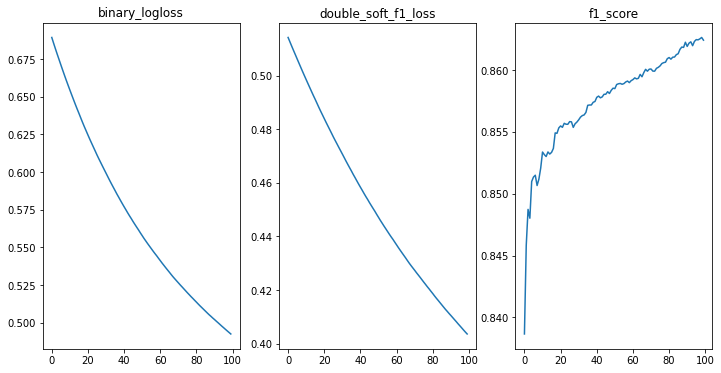

In [35]:
clf = train_lgbm(eval_sets)
plot_evals(clf)

## optuna optimization

In [9]:
def objective(trial, train_df):
    # hyperparameter grid for Optuna to explore
    hyperparams = {
        "device_type": trial.suggest_categorical("device_type", ["gpu"]),
        # structure
        "max_depth": trial.suggest_int("max_depth", 3, 12, step=1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        # accuracy
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        # overfitting
        #"max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }
    
    # split features and labels
    x_df = train_df.loc[:, ~train_df.columns.isin(["LABELS"])]
    y_df = train_df.loc[:, "LABELS"]
    # create cross-validation folds object
    kfold_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    # hold the best score of each fold
    cv_scores = []
    for idx, (train_idx, test_idx) in enumerate(kfold_cv.split(x_df, y_df)):
        # train-validation split for each fold
        x_train, x_test = x_df.iloc[train_idx], x_df.iloc[test_idx]
        y_train, y_test = y_df.iloc[train_idx], y_df.iloc[test_idx]
        
        # train classifier with optuna hyperparameters
        clf = LGBMClassifier(objective="binary", verbose=-1, **hyperparams)
        clf.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric=["logloss", "double_soft_f1_loss"],
            verbose=False,
        )
        
        # store the best score to the CV score
        best_score = clf.best_score_["valid_0"]["binary_logloss"]#["double_soft_f1_loss"]
        cv_scores.append(best_score)
    
    # return the average best score across CV folds
    return np.mean(cv_scores)

In [10]:
# create optuna study
study = optuna.create_study(direction="minimize", study_name="lgbm3")
optimize = lambda trial: objective(trial, train_df)

[I 2021-11-28 10:13:30,166] A new study created in memory with name: lgbm3


In [11]:
# launch optuna study
study.optimize(optimize, n_trials=2)

C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [20, 3000] and step=50, but the range is not divisible by `step`. It will be replaced by [20, 2970].
  warnings.warn(
C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=1.6495219687927398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6495219687927398
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will

In [36]:
# function to display optuna's best parameters
# not all parameters are displayed, just those from the grid
def study_summary(study):
    print("Study: ", study.study_name)
    print("\nNumber of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Validation score: {}".format(trial.value))
    print("  Params: ")
    for key, val in trial.params.items():
        print("    {}: {}".format(key, val))

In [37]:
study_summary(study)

Study:  lgbm3

Number of finished trials: 2
Best trial:
  Validation score: 0.39333555722267294
  Params: 
    device_type: gpu
    max_depth: 11
    num_leaves: 1120
    min_data_in_leaf: 9500
    learning_rate: 0.22578944688015531
    n_estimators: 500
    lambda_l1: 15
    lambda_l2: 75
    min_gain_to_split: 1.6495219687927398


In [38]:
# train LGBM on the whole training set for final predictions
def train_best_lgbm(train_df, hyperparams):
    x_train = train_df.loc[:, ~train_df.columns.isin(["LABELS"])].values
    y_train = train_df.loc[:, "LABELS"].values
    
    clf = LGBMClassifier(objective="binary", verbose=-1, **hyperparams)
    clf.fit(
        x_train,
        y_train,
        eval_metric=["logloss", "double_soft_f1_loss"],
        verbose=False,
    )
    
    return clf

In [39]:
# pass the optuna best parameters as hyperparameters
best_clf = train_best_lgbm(train_df, study.best_params)

C:\Users\TJ\miniconda3\envs\kaggle2\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
preds = best_clf.predict(test_df)

# Save prediction

In [ ]:
# save the .csv file to submission folder
def save_pred(y, sub_id):
    original_index = test_df.index
    output_df = pd.DataFrame(y, index=original_index, columns=["LABELS"], dtype=int)
    output_df.to_csv(f"./submission/submission{sub_id}.csv")

In [ ]:
save_pred(preds, 3)